## Predict A5SS with HAL

In [1]:
import kipoi
from kipoi.model import KerasModel
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
%matplotlib inline 

from mmsplice.exon_dataloader import ExonDataset
from mmsplice import MMSplice
from mmsplice.generic import expit, logit

from kipoi.data import DataLoader
from kipoi.data_utils import numpy_collate

from keras.models import load_model
from concise.preprocessing import encodeDNA

%load_ext autoreload
%autoreload 2

projectDIR = "../../data/"

/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/li

In [2]:
dl1 = ExonDataset(projectDIR+"gtex/A5SS_SD1_variant.csv",
                  projectDIR+"shared/hg19.fa", split_seq=False, overhang=(80,80))

In [3]:
dl2 = ExonDataset(projectDIR+"gtex/A5SS_SD2_variant.csv",
           projectDIR+"shared/hg19.fa", split_seq=False, overhang=(80,80))

In [4]:
dl1 = DataLoader(dl1, batch_size=dl1.__len__(), collate_fn=numpy_collate, shuffle=False)
dl1 = iter(dl1)
dt1 = next(dl1)

In [5]:
dl2 = DataLoader(dl2, batch_size=dl2.__len__(), collate_fn=numpy_collate, shuffle=False)
dl2 = iter(dl2)
dt2 = next(dl2)

In [6]:
df = pd.read_csv(projectDIR+"gtex/A5SS_PSI.csv", index_col=0)
df = df.reset_index()

In [7]:
df['SD1_REF_SEQ'] = dt1['inputs']['seq']
df['SD1_ALT_SEQ'] = dt1['mut_inputs']['seq']

In [8]:
df['SD2_REF_SEQ'] = dt2['inputs']['seq']
df['SD2_ALT_SEQ'] = dt2['mut_inputs']['seq']

## Score with HAL and MaxEnt

In [9]:
def getHALseq(x):
    ''' Get HAL required sequence, only for SDs
    '''
    return (x.SD1_REF_SEQ[-83:-74], x.SD2_REF_SEQ[-83:-74]), (x.SD1_ALT_SEQ[-83:-74], x.SD2_ALT_SEQ[-83:-74])

In [10]:
import scipy.io as sio
import sys
sys.path.append("/data/ouga/home/ag_gagneur/chengju/project/recods/Scripts/")
from dnatools import make_mer_list # got from HAL paper code
data = sio.loadmat(projectDIR+'model_full_data.mat')
sd_scores = pd.DataFrame(index=make_mer_list(6),data=data['Mer_scores'][:4**6*8].reshape(4**6,8)[:,2:6])

In [11]:
def score_seq_HAL(sd_pair):
    score = 0
    SD1, SD2 = sd_pair
    for b in range(4):
        score -= sd_scores.loc[SD1[b:b+6],b]
        score += sd_scores.loc[SD2[b:b+6],b]
    return score

In [12]:
from maxentpy import maxent
def score_seq_MaxEnt(sd_pair):
    SD1, SD2 = sd_pair
    return maxent.score5(SD2) - maxent.score5(SD1)

In [13]:
def score_diff(x, m='HAL', hetero=False):
    wt, mut = getHALseq(x)
    if m=='HAL':  
        effect_size = score_seq_HAL(mut) - score_seq_HAL(wt)
    else:
        wt_score = score_seq_MaxEnt(wt)
        mut_score = score_seq_MaxEnt(mut)
        if hetero:
            effect_size = (wt_score + mut_score) / 2 - wt_score
        else:
            effect_size = mut_score - wt_score
    return effect_size

In [14]:
hal_pred = df.apply(score_diff, axis=1)
maxent_pred_homo = df.apply(lambda x: score_diff(x, m='MaxEnt', hetero=False), axis=1)
maxent_pred_hetero = df.apply(lambda x: score_diff(x, m='MaxEnt', hetero=True), axis=1)

In [16]:
ref_psi = df.WT_MEAN.values
PSI_MUT = expit(logit(ref_psi)+hal_pred)

In [17]:
df['HOMO_dPSI'] = PSI_MUT - ref_psi
df['HETERO_dPSI'] = (PSI_MUT+ref_psi)/2 - ref_psi
df['dMaxEnt_homo'] = maxent_pred_homo
df['dMaxEnt_hetero'] = maxent_pred_hetero

In [18]:
df_HOMO = df[~df.HOMO_MEAN.isna()]
df_HETERO = df[~df.HETERO_MEAN.isna()]

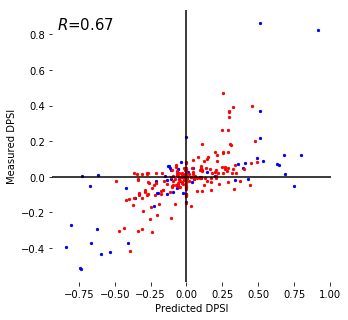

In [19]:
pred = np.concatenate([df_HOMO['HOMO_dPSI'], df_HETERO['HETERO_dPSI']])
measured = np.concatenate([df_HOMO['HOMO_MEAN'] - df_HOMO['WT_MEAN'], df_HETERO['HETERO_MEAN'] - df_HETERO['WT_MEAN']])
r = pearsonr(pred, measured)[0]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# ax.axis([-1,1,-1,1])
ax.scatter(df_HOMO['HOMO_dPSI'], df_HOMO['HOMO_MEAN'] - df_HOMO['WT_MEAN'], s=5, c='b')
ax.scatter(df_HETERO['HETERO_dPSI'], df_HETERO['HETERO_MEAN'] - df_HETERO['WT_MEAN'], s=5, c='r')
ax.text(-0.9,0.9,'$R$=%0.2f' %r,fontsize=15,ha='left',va='top')
ax.set_xlabel("Predicted DPSI")
ax.set_ylabel("Measured DPSI")
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

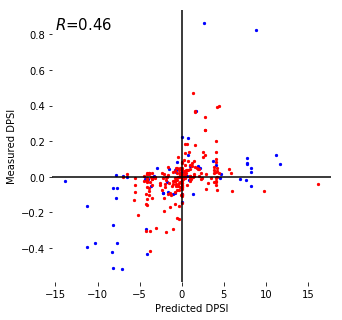

In [20]:
pred = np.concatenate([df_HOMO['dMaxEnt_homo'], df_HETERO['dMaxEnt_hetero']])
measured = np.concatenate([df_HOMO['HOMO_MEAN'] - df_HOMO['WT_MEAN'], df_HETERO['HETERO_MEAN'] - df_HETERO['WT_MEAN']])
r = pearsonr(pred, measured)[0]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# ax.axis([-1,1,-1,1])
ax.scatter(df_HOMO['dMaxEnt_homo'], df_HOMO['HOMO_MEAN'] - df_HOMO['WT_MEAN'], s=5, c='b')
ax.scatter(df_HETERO['dMaxEnt_hetero'], df_HETERO['HETERO_MEAN'] - df_HETERO['WT_MEAN'], s=5, c='r')
ax.text(-15,0.9,'$R$=%0.2f' %r,fontsize=15,ha='left',va='top')
ax.set_xlabel("Predicted DPSI")
ax.set_ylabel("Measured DPSI")
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [21]:
df_HOMO.to_csv(projectDIR + "gtex/HAL_SD_HOMO.csv")
df_HETERO.to_csv(projectDIR + "gtex/HAL_SD_HETERO.csv")